In [1]:
import sys
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import manhattan_distances

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Reshape
from tensorflow.keras.constraints import MinMaxNorm

sys.path.append("../")
sys.path.append("../dbal")
from query_methods import *
from training_models import *
from utils import *

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
pd.set_option('display.max_columns', 500)

In [2]:
if not os.path.isfile("../datasets/superconductivity/train.csv"):
    os.makedirs("../datasets/superconductivity", exist_ok=True)
    download_superconductivity()

source = 2
target = 3
    
Xs, ys = load_superconductivity(source)
Xt, yt = load_superconductivity(target)
X = np.concatenate((Xs, Xt))
y = np.concatenate((ys, yt))
src_index = np.array(range(len(Xs)))
tgt_index = np.array(range(len(Xs), len(Xs) + len(Xt)))

X, y, convert_y = preprocessing_superconductivity(X, y, src_index)

In [3]:
def get_base_model(input_shape, output_shape=(1,), C=1):
    inputs = Input(shape=input_shape)
    modeled = Flatten()(inputs)
    modeled = Dense(100, activation='relu',
                         kernel_constraint=MinMaxNorm(0, C),
                         bias_constraint=MinMaxNorm(0, C))(modeled)
    modeled = Dense(100, activation='relu',
                         kernel_constraint=MinMaxNorm(0, C),
                         bias_constraint=MinMaxNorm(0, C))(modeled)
    modeled = Dense(np.prod(output_shape), activation=None,
                    kernel_constraint=MinMaxNorm(0, C),
                    bias_constraint=MinMaxNorm(0, C))(modeled)
    model = Model(inputs, modeled)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [4]:
n_samples = 20
seed = 0
fit_params = dict(epochs=100, batch_size=128, verbose=0)
model = BalanceWeighting(get_base_model)

## Query Methods

### Random

In [6]:
np.random.seed(0); tf.random.set_seed(0)
random = RandomQuery()
random.fit(X, y, src_index, tgt_index, n_samples, **fit_params)
queries = tgt_index[random.predict()]
model.fit(X, y, src_index, queries, **fit_params);
test_index = np.array(list(set(tgt_index) - set(queries)))
y_pred = convert_y(model.predict(X[test_index]).ravel())

score_random = mean_absolute_error(y_pred, convert_y(y[test_index]))
print("Score on Unlabeled Target: %.3f"%score_random)

Score on Unlabeled Target: 11.043


### K-means

In [7]:
np.random.seed(0); tf.random.set_seed(0)
kmeans = KMeansQuery()
kmeans.fit(X, y, src_index, tgt_index, n_samples, **fit_params)
queries = tgt_index[kmeans.predict()]
model.fit(X, y, src_index, queries, **fit_params);
test_index = np.array(list(set(tgt_index) - set(queries)))
y_pred = convert_y(model.predict(X[test_index]).ravel())

score_kmeans = mean_absolute_error(y_pred, convert_y(y[test_index]))
print("Score on Unlabeled Target: %.3f"%score_kmeans)

minibatch False
Score on Unlabeled Target: 10.326


### K-center

In [8]:
np.random.seed(0); tf.random.set_seed(0)
kcenter = KcenterGreedy()
kcenter.fit(X, y, src_index, tgt_index, n_samples, **fit_params)
queries = tgt_index[kcenter.predict()]
model.fit(X, y, src_index, queries, **fit_params);
test_index = np.array(list(set(tgt_index) - set(queries)))
y_pred = convert_y(model.predict(X[test_index]).ravel())

score_kcenter = mean_absolute_error(y_pred, convert_y(y[test_index]))
print("Score on Unlabeled Target: %.3f"%score_kcenter)

Score on Unlabeled Target: 10.634


### Diversity

In [9]:
np.random.seed(0); tf.random.set_seed(0)
divers = Diversity()
divers.fit(X, y, src_index, tgt_index, n_samples, **fit_params)
queries = tgt_index[divers.predict()]
model.fit(X, y, src_index, queries, **fit_params);
test_index = np.array(list(set(tgt_index) - set(queries)))
y_pred = convert_y(model.predict(X[test_index]).ravel())

score_divers = mean_absolute_error(y_pred, convert_y(y[test_index]))
print("Score on Unlabeled Target: %.3f"%score_divers)

Score on Unlabeled Target: 10.532


### QBC

In [10]:
np.random.seed(0); tf.random.set_seed(0)
qbc = QueryByComitee(get_base_model)
qbc.fit(X, y, src_index, tgt_index, n_samples, **fit_params)
queries = tgt_index[qbc.predict()]
model.fit(X, y, src_index, queries, **fit_params);
test_index = np.array(list(set(tgt_index) - set(queries)))
y_pred = convert_y(model.predict(X[test_index]).ravel())

score_qbc = mean_absolute_error(y_pred, convert_y(y[test_index]))
print("Score on Unlabeled Target: %.3f"%score_qbc)

minibatch False
Score on Unlabeled Target: 10.272


### K-medoids

In [11]:
np.random.seed(0); tf.random.set_seed(0)
kmedoids = KMedoidsGreedy()
kmedoids.fit(X, y, src_index, tgt_index, n_samples, **fit_params)
queries = tgt_index[kmedoids.predict()]
model.fit(X, y, src_index, queries, **fit_params);
test_index = np.array(list(set(tgt_index) - set(queries)))
y_pred = convert_y(model.predict(X[test_index]).ravel())

score_kmedoids = mean_absolute_error(y_pred, convert_y(y[test_index]))
print("Score on Unlabeled Target: %.3f"%score_kmedoids)

Score on Unlabeled Target: 8.845


## Results Summary

minibatch False
minibatch False


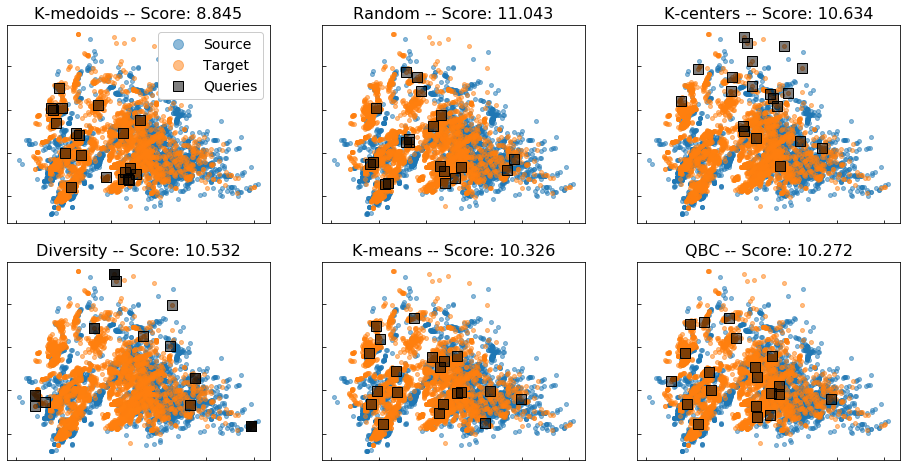

In [15]:
np.random.seed(0)
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
Xt = PCA(2).fit_transform(X)

for method, ax, name, score in zip([kmedoids, random, kcenter, divers, kmeans, qbc],
                           axes.ravel(),
                           ["K-medoids", "Random", "K-centers", "Diversity", "K-means", "QBC"],
                                  [score_kmedoids, score_random, score_kcenter, score_divers, score_kmeans, score_qbc]):
    queries = tgt_index[method.predict(20)]
    ax.plot(Xt[src_index, 0], Xt[src_index, 1], '.', ms=8, label="Source", alpha=0.5)
    ax.plot(Xt[tgt_index, 0], Xt[tgt_index, 1], '.', ms=8, label="Target", alpha=0.5)
    ax.plot(Xt[queries, 0], Xt[queries, 1], 's', ms=10, markerfacecolor=(0,0,0,0.5), label="Queries", markeredgecolor=(0,0,0,1))
    
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(direction ='in')
    ax.set_title("%s -- Score: %.3f"%(name, score), fontsize=16)
    
    if method.__class__.__name__ == "KMedoidsGreedy":
        lgd = ax.legend(loc='upper right', framealpha=1, fontsize=14)
        
        lgd.legendHandles[0]._legmarker.set_markersize(20)
        lgd.legendHandles[1]._legmarker.set_markersize(20)
plt.show()